コードが動かない場合にはAPIやライブラリ等がアップデートしている可能性があります。その際には以下のGitHubページにて更新情報がないかご確認ください。

https://github.com/tamanome/satelliteBook

# 階層クラスタリング

階層クラスタリングは教師なし学習でよく使われる手法です。階層クラスタリングはかなりのマシンパワーが必要な処理のため、GPUを利用したデータ処理を推奨しています。そのため、この章ではGoogle Colabを利用した解析を前提にするとともに、解析範囲を狭めます。

以下の流れで説明します。
階層クラスタリングとは？
階層クラスタリングの数学的背景
実際にやってみよう


Google Colabを利用されている方は「ランタイム」→「ランタイムのタイプを変更」をクリックし、ハードウェアアクセラレータで「GPU」を選択してください。

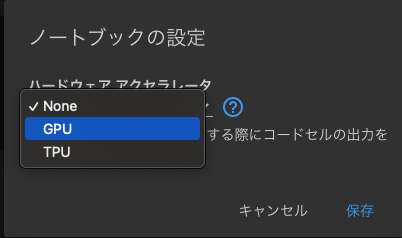

## Step1:ライブラリのインポート

In [ ]:
!nvidia-smi

Thu Dec 15 21:00:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 15 21:00:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')



Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install rasterio
!pip install earthengine-api --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step2:シーン検索と必要なデータの抽出

GEEのAPIからデータを取得するための認証を行います。GEEでのアカウント登録が必要です。GEEのサイトから、Sing Upにてアカウントを登録しましょう。
まだ登録していない方は以下の画面からトークンを生成しましょう。

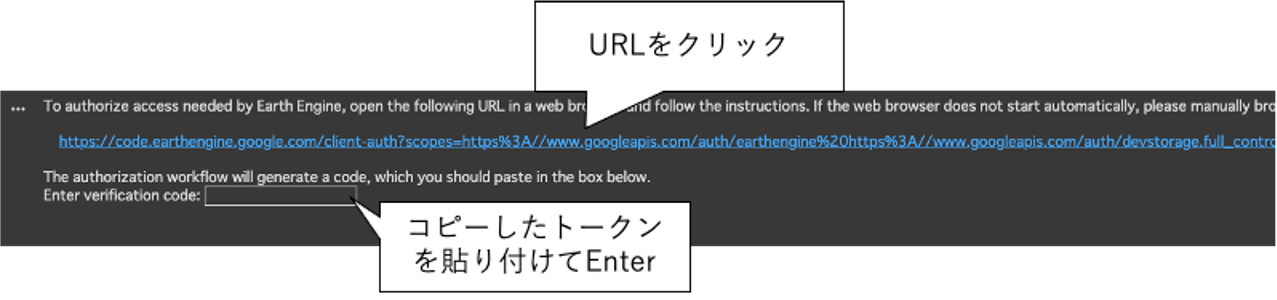

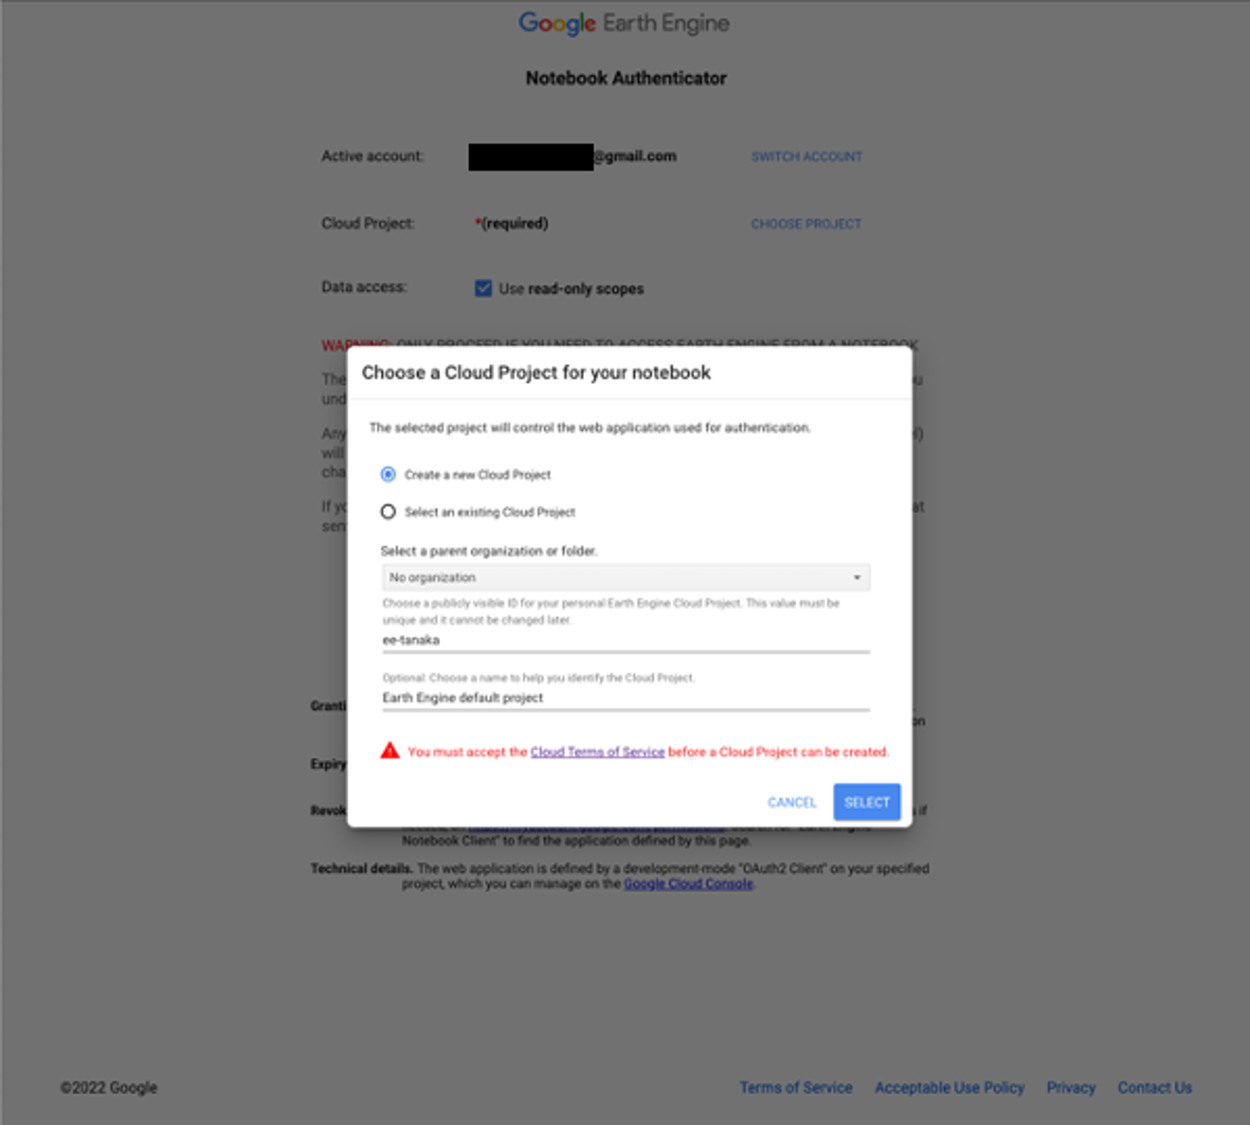

承認を進めると以下のような画面になりますので、トークンをコピーしましょう。

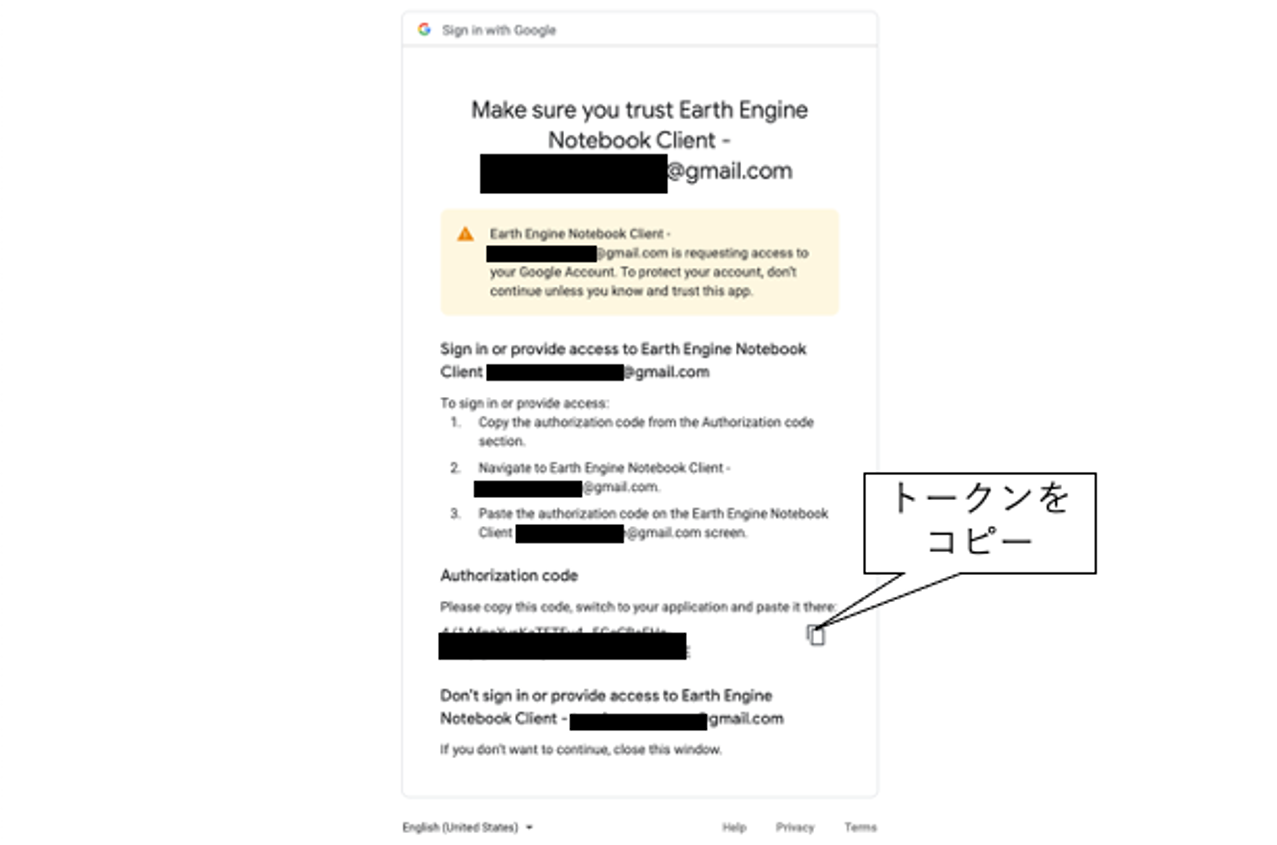

In [ ]:
# Earth Engine Python APIのインポート
import ee
# GEEの認証・初期化
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=IQOXzAaf8f5FrTLxir9T-k-TOM7aXginGaWmukJeP3o&tc=1fUspBEXz00b0AE7MlgaeOrlT98OHEqcmZif9riYm5g&cc=RUBSKWg-YLbABh2RlWpN8PEvFfeQZhp7JLJmu1aeoLM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdcsLHV1lnN039SgcDM8y1S1Mwbw1CKHOwu6mVc2A7D2ipeIcaGXDyA

Successfully saved authorization token.


In [ ]:
# 衛星画像を指定（Landsat 8）
Landsat8 = ee.Image('LANDSAT/LC08/C01/T1_RT/LC08_106030_20170905').select(['B5', 'B4', 'B3', 'B2']) #RGBのバンドを指定

# 釧路周辺のエリアを設定
region = ee.Geometry.Rectangle([144.38671875, 43.0046135, 144.45703125,  42.94033923])

In [ ]:
# Google Driveのフォルダにエクスポート
task = ee.batch.Export.image.toDrive(**{
    'image': Landsat8,
    'description': 'imagetoDrive_L8', #ファイル名
    'folder': 'Example_Data', #フォルダ名
    'scale': 30,
    'region': region.getInfo()['coordinates'],
    'crs': 'EPSG:4326'
})
task.start()
print('Done.')

Done.


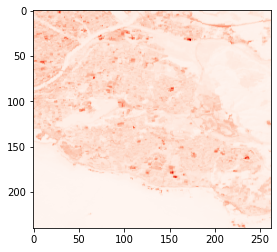

In [ ]:
# データの読み込み
with rasterio.open('/content/drive/My Drive/Example_Data/imagetoDrive_L8.tif') as src:
    arr = src.read()

# 可視化
plt.imshow(arr[1], cmap='Reds')

In [ ]:
arr[0, :, :].shape

(240, 262)

## Step3:特徴量の抽出


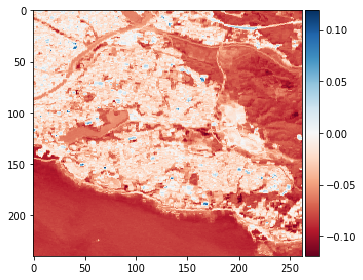

In [ ]:
from skimage import io

# 正規化計算の関数を定義
def calc_normalized_index(band1, band2):
   shape = band1.shape
   assert shape == band2.shape, 'Two images are different sizes.'
  
   b1 = band1.flatten().astype(np.float32)
   b2 = band2.flatten().astype(np.float32)
   numer = b1 - b2
   denom = b1 + b2
   normalized_index = np.where(denom != 0, numer / denom, 0)
   return normalized_index.reshape(shape)

# 正規化指標の計算をする
calc_img = calc_normalized_index(arr[1, :, :], arr[2, :, :])

# NDVI画像を表示
io.imshow(calc_img)

In [ ]:
nir_arr = arr[0, :, :].reshape([-1, 1]).astype(np.float32) #nir array
red_arr = arr[1, :, :].reshape([-1, 1]).astype(np.float32) #red array
green_arr = arr[2, :, :].reshape([-1, 1]).astype(np.float32) #green array
blue_arr = arr[3, :, :].reshape([-1, 1]).astype(np.float32) #blue array

# 特徴量のarrayを作成
features_arr = np.concatenate([nir_arr, red_arr, green_arr, blue_arr], axis=1)
features_arr

array([[10805.,  8844.,  9083.,  9774.],
       [11470.,  9541.,  9526.,  9905.],
       [11470.,  9541.,  9526.,  9905.],
       ...,
       [ 5564.,  6252.,  7459.,  8665.],
       [ 5590.,  6267.,  7489.,  8708.],
       [ 5591.,  6220.,  7402.,  8630.]], dtype=float32)

In [ ]:
features_arr.shape

(62880, 4)

## Step4:分類の実行

それでは特徴量を用いて、階層クラスタリングによる分類を試してみましょう。今回は5クラスに分類してみます。
今回はscipyのclusterモジュールを使用します。詳しくは公式ドキュメントを参照してください。 


In [ ]:
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

#引数でウォード法を指定
Z = linkage(features_arr, method='ward', metric='euclidean')
pd.DataFrame(Z)

,0,1,2,3
0,6176.0,6177.0,0.000000e+00,2.0
1,1.0,2.0,0.000000e+00,2.0
2,32702.0,32703.0,0.000000e+00,2.0
3,53.0,54.0,0.000000e+00,2.0
4,15224.0,15225.0,0.000000e+00,2.0
...,...,...,...,...
62874,125751.0,125753.0,2.591588e+05,24376.0
62875,125746.0,125752.0,2.800649e+05,14846.0
62876,125750.0,125754.0,4.271913e+05,32959.0
62877,125748.0,125756.0,1.037533e+06,48034.0


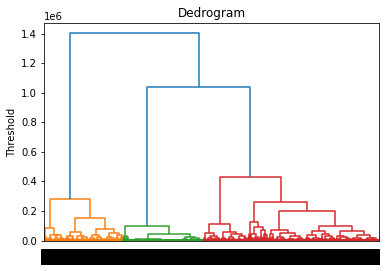

In [ ]:
dendrogram(Z)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

## Step5:指定したクラスタ数でクラスタを得る

クラスタの作成方法には、適切に閾値を設定する方法と、指定したクラスタ数を設定する方法があります。今回は4つのクラスタ数を指定して、クラスタを作成します。

In [ ]:
# 指定したクラスタ数でクラスタを得る関数を作る。
def get_cluster_by_number(result, number):
   output_clusters = []
   x_result, y_result = result.shape
   n_clusters = x_result + 1
   cluster_id = x_result + 1
   father_of = {}
   x1 = []
   y1 = []
   x2 = []
   y2 = []
   for i in range(len(result) - 1):
       n1 = int(result[i][0])
       n2 = int(result[i][1])
       val = result[i][2]
       n_clusters -= 1
       if n_clusters >= number:
           father_of[n1] = cluster_id
           father_of[n2] = cluster_id

       cluster_id += 1

   cluster_dict = {}
   for n in range(x_result + 1):
       if n not in father_of:
           output_clusters.append([n])
           continue

       n2 = n
       m = False
       while n2 in father_of:
           m = father_of[n2]
           #print [n2, m]
           n2 = m

       if m not in cluster_dict:
           cluster_dict.update({m:[]})
       cluster_dict[m].append(n)

   output_clusters += cluster_dict.values()

   output_cluster_id = 0
   output_cluster_ids = [0] * (x_result + 1)
   for cluster in sorted(output_clusters):
       for i in cluster:
           output_cluster_ids[i] = output_cluster_id
       output_cluster_id += 1

   return output_cluster_ids

In [ ]:
clusterIDs = get_cluster_by_number(Z, 4)
print(clusterIDs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Step6:分類結果の可視化
最後に分類結果を可視化してみます。

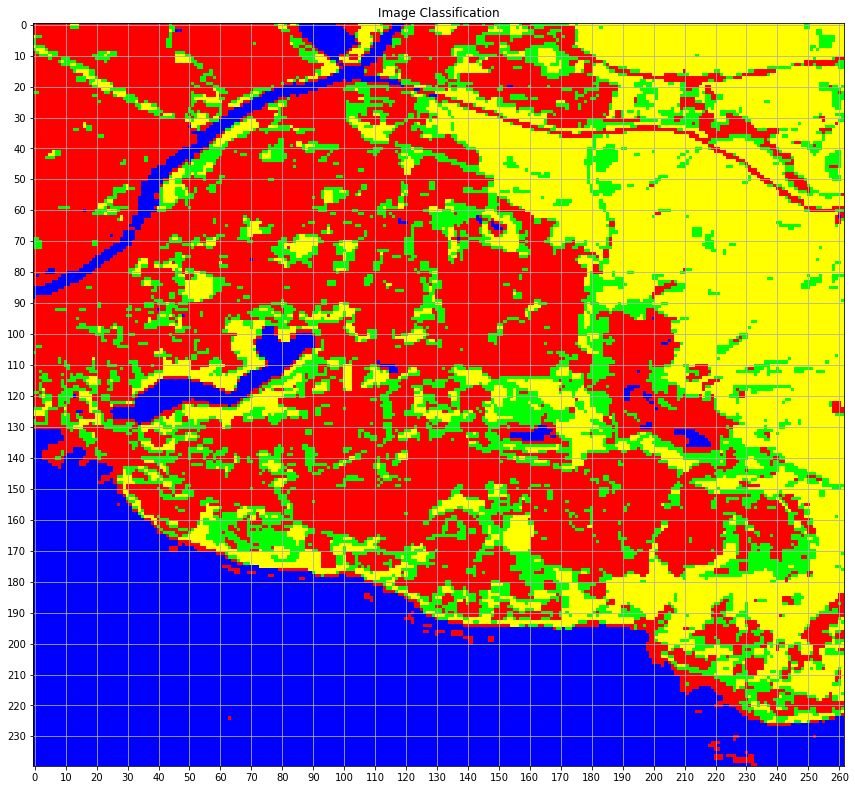

In [ ]:
classified_img = np.array(clusterIDs).reshape((240, -1))

palette = np.uint8([[255, 0, 0],  [255, 255, 0], [0, 255, 0], [0, 0, 255]])

plt.figure(figsize = (12,12))
plt.xticks(np.arange(0, 600, step=10))
plt.yticks(np.arange(0, 300, step=10))
plt.grid()
plt.title('Image Classification')
io.imshow(palette[classified_img])

In [ ]:
np.save('/content/drive', classified_img)



## Step7:分類精度の評価

最後に分類結果の精度を評価します。分類精度の評価には通常、混合行列（Confusion Matrix; 分類精度行列, 判別効率表などとも言う）を利用して表現します。これはクラス分類問題の結果を、「実際のクラス」と「予測したクラス」を軸として、表形式にまとめたものです。

検証データには、[宇宙航空研究開発機構 (JAXA)が公開している高解像度土地利用土地被覆図](https://www.eorc.jaxa.jp/ALOS/jp/dataset/lulc_j.htm)を利用します（ダウンロードにはユーザー登録が必要です）。今回は分類に用いた衛星画像の撮影時期を考慮して、日本域10m解像度【2018 - 2020年】(ver.21.11）を使用します。Step.5までで作成した土地被覆分類結果を予測クラス、高解像度土地利用土地被覆図を実際のクラスとして混合行列を作成します。


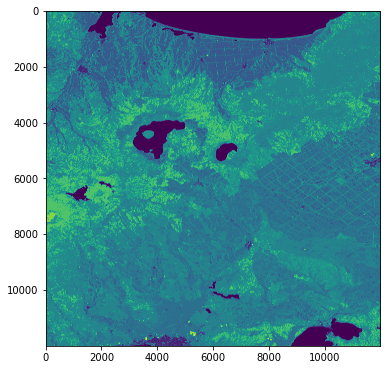

In [ ]:
from osgeo import gdal, gdalconst, gdal_array


#1枚目
im1 = 'LC_N43E144.tif'
tif1 = gdal.Open(im1, gdalconst.GA_ReadOnly) # gdal.Openを使って画像を読み込み
imgArray1 = tif1.ReadAsArray() #画像を配列情報（Array）にする
plt.figure(figsize = (6,12))
plt.imshow(imgArray1)

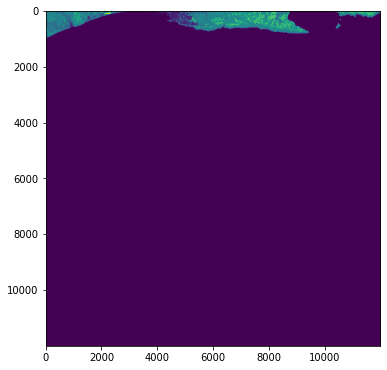

In [ ]:
#2枚目
im2 = 'LC_N42E144.tif'
tif2 = gdal.Open(im2, gdalconst.GA_ReadOnly)
imgArray2 = tif2.ReadAsArray()
plt.figure(figsize = (6,12))
plt.imshow(imgArray2)

In [ ]:
# 自身の環境から、gdal_mergeがどこにあるか"which"コマンドで確認します。
!which gdal_merge.py



/usr/bin/gdal_merge.py


In [ ]:
import sys
sys.path.append('/usr/bin/')
import gdal_merge

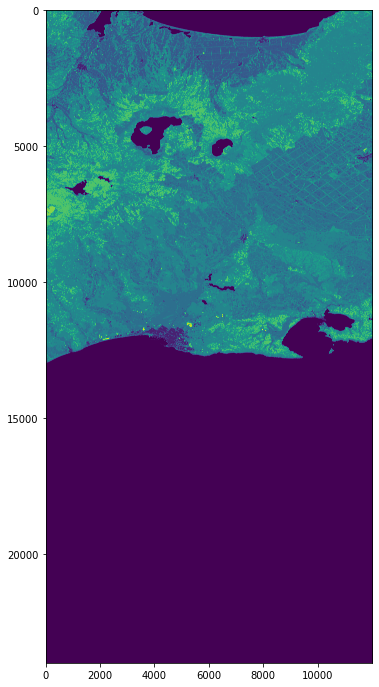

In [ ]:
#　2つの検証データ画像を結合する
#　gdal_merge.main(["","-o",{出力画像},"-separate",{入力画像１},{入力画像２},{入力画像３}])
gdal_merge.main(["", "-o", "val_im.tif", im1, im2])
#2枚の画像を1枚に結合した画像を表示
val_tif = gdal.Open("val_im.tif", gdalconst.GA_ReadOnly)
imgArray_val = val_tif.ReadAsArray()
plt.figure(figsize = (6,12))
plt.imshow(imgArray_val)

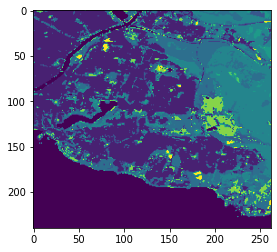

In [ ]:
# 以下の名前で保存
cut_val_tif_path = "cut_val_im.tif"

bbox = [144.38671875, 43.0046135, 144.45703125,  42.94033923]

# gdal.Translateを使って関心領域を切り出す
# gdal.Translate(｛出力画像名｝,{入力画像名}, width={X軸方向のピクセル数}, height={Y軸方向のピクセル数}, projWin=[xmin ymax xmax ymin], resampleAlg={nearest, averageなど})
cut_val_tif = gdal.Translate(cut_val_tif_path, val_tif, width=262, height=240, projWin=bbox, resampleAlg="nearest")
cut_val_tif = None
# gdal.Openを使って画像読み込み
cut_val_tif_im = gdal.Open(cut_val_tif_path)

# 画像をarrayとする
cut_val_tif_arr = cut_val_tif_im.ReadAsArray()
plt.imshow(cut_val_tif_arr)



In [ ]:
cut_val_tif_arr.shape

(240, 262)

しかし今回Landsat画像を4クラスに分類したのに対して、検証データは13クラスに分類されています。これを合わせる必要があります。
Landsat画像はクラスの番号順に人工物（0）、草地/農地（1）、森林（2）、水域（3）に分類しました。検証データを以下のような分類クラスに直します。

0: 未分類 (Unclassified)

1: 水域 (Water)　 → 水域

2: 都市 (Urban) → 人工物

3: 水田 (Rice paddy) → 草地/農地

4: 畑地 (Crops) → 草地/農地

5: 草地 (Grassland) → 草地/農地

6: 落葉広葉樹 (DBF) → 森林

7: 落葉針葉樹 (DNF) → 森林

8: 常緑広葉樹 (EBF) → 森林

9: 常緑針葉樹 (ENF) → 森林

10: 裸地 (Bare land) → 草地/農地

11: 竹林 (Bamboo) → 森林

12: ソーラーパネル(Solar panel) → 人工物


In [ ]:
# 未分類(Unclassified)があるかどうか確認
val_arr = cut_val_tif_arr.copy() # 検証データのarrayをコピーして使用
print(np.where(val_arr == 0))

(array([], dtype=int64), array([], dtype=int64))


In [ ]:
# np.selectを使って検証データの分類クラスをLandsat分類クラスに置換
val_arr = np.select([val_arr == 1, val_arr == 2, val_arr == 3, val_arr == 4, val_arr == 5, val_arr == 6, val_arr == 7, val_arr == 8,
           val_arr == 9, val_arr == 10, val_arr == 11, val_arr == 12], [3, 0, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0])
print(val_arr)

[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


In [ ]:
from sklearn.metrics import confusion_matrix

val_class = val_arr.flatten()
output_class = classified_img.flatten()
labels = [0, 1, 2, 3]

# confusion_matrix({検証データ},{分類結果データ})
cm = confusion_matrix(val_class, output_class, labels=labels)

print(cm)

[[19006   705  2792   113]
 [ 4391  6536  4606   337]
 [  497  7593  1141     8]
 [  482    12    44 14617]]


In [ ]:
# カラム名
columns = ['都市', '草地/農地', '森林', '水域']

n = len(columns)

actual = ['正解データ'] * n
pred = ['推定結果'] * n

# DataFrameを作成
cm_df = pd.DataFrame(cm, columns=[pred, columns], index=[actual, columns])

cm_df

推定結果                   
                都市 草地/農地    森林     水域
正解データ 都市     19006   705  2792    113
      草地/農地   4391  6536  4606    337
      森林       497  7593  1141      8
      水域       482    12    44  14617